# Wykrywanie naczyń dna siatkówki oka

- Jakub Rapsiewicz: 148180
- Paweł Woźniak: 148168

## Funkcje pomocnicze

Funkcje pomocnicze są wykorzystywane przez wszystkie 3 metody segmentacji naczyń dna oka, dlatego ich definicja znajduje się na samym początku. Poniżej znajdują się też globalne stałe wykorzystywane w całym notebooku, dotyczą one głównie ładowania i zapisywania danych.

In [99]:
DATA_DIR = "data"
GOLD_STANDARD_DIR = "manual1" 
FOV_DIR = "mask"
IMAGE_DIR = "images"
RESULTS_DIR = "results"

### Operacje na danych

Poniższe funkcje implementują mechanizm ładowania zdjęć dna oka, obrazów field of view, oraz masek gold standard ze zbioru **HSF**. Upraszcza to kod skupiając się tylko na "nazwach próbek" (`sample_name`), co w naszym zbiorze składa się na numer próbki oraz kod oznaczający typ oka: (`h` - healthy, `dr` - diabetic retinopathy, `g` - glaucomatous eyes).

In [100]:
from pathlib import Path
from typing import List
import cv2

def load_image(sample_name: str):
    sample_dir = Path(DATA_DIR) / Path(IMAGE_DIR)

    for ext in [ '.jpg', '.JPG' ]:
        sample = sample_dir / Path(sample_name + ext)
        if sample.is_file: 
            return cv2.cvtColor(cv2.imread(str(sample)), cv2.COLOR_BGR2RGB)

    raise FileNotFoundError

def load_fov(sample_name: str):
    sample_dir = Path(DATA_DIR) / Path(FOV_DIR)

    sample = sample_dir / Path(sample_name + '_mask.tif')
    if not sample.is_file:
        raise FileNotFoundError

    return cv2.imread(str(sample), cv2.IMREAD_GRAYSCALE)

def load_gold_standard(sample_name: str):
    sample_dir = Path(DATA_DIR) / Path(GOLD_STANDARD_DIR)

    sample = sample_dir / Path(sample_name + '.tif')
    if not sample.is_file:
        raise FileNotFoundError

    # load image in grayscale
    return cv2.imread(str(sample), cv2.IMREAD_GRAYSCALE)

def load_sample_data(sample_name: str):
    image = load_image(sample_name)
    gold_standard = load_gold_standard(sample_name)
    fov_mask = load_fov(sample_name)
    
    return (image, gold_standard, fov_mask)

def get_all_sample_names() -> List[str]:
    """ Return list of strings - names of given samples. We can get from names to images, fovs, and gold_standards """
    
    # Use files from Gold Standards, because they have basic names + tif extension
    samples_dir = Path(DATA_DIR) / Path(GOLD_STANDARD_DIR)

    # data/manual1/01_dr.tif -> 01_dr
    sample_names = [ sample_file.stem for sample_file in samples_dir.iterdir() ] 
    return sample_names
    


### Funkcje Statystyczne

W celu zestawienia parametrów klasyfikacji algorytmów, korzystamy z gotowego wyliczania macierzy pomyłek (`confusion_matrix`) z pakietu `sklearn.metrics`. Na postawie 4 otrzymanych parametrów klasyfikacji binarnej (T/F) liczymy:
- _trafność_ (ang. accuracy)
- _czułość_ (ang. sensitivity)
- _swoistość_ (ang. specificity)
- średnią ze swoistości i czułości -> `mean(sens, spec)`
- średnią geometryczną ze swoistości i czułości -> `geo_mean(sens, spec)`

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())

def calculate_mask_statistics(gold_standard, mask):
    # Assume vmin = 0, vmax = 255, type = uint8t
    assert gold_standard.shape == mask.shape

    cm = confusion_matrix(gold_standard.flatten(), mask.flatten())
    tn, fp, fn, tp = cm.ravel()

    cm_accuracy = tp / (tp + fp)
    cm_specificity = tn / (tn + fp)
    cm_sensitivity = tp / (tp + fn)
    
    cm_mean = (cm_specificity + cm_sensitivity) / 2
    cm_geo = geo_mean_overflow([cm_specificity, cm_sensitivity]) 

    return (cm_accuracy, cm_specificity, cm_sensitivity, cm_mean, cm_geo)

def print_statistics(gold_standard, mask):
    acc, spec, sens, mean_spec_sens, geo_spec_sens = calculate_mask_statistics(gold_standard, mask)

    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Sensitivity: {spec * 100:.2f}%")
    print(f"Specificity: {sens * 100:.2f}%")
    print(f"Mean(spec, sens): {mean_spec_sens * 100:.2f}%")
    print(f"GeoMean(spec, sens): {geo_spec_sens * 100:.2f}%")

### Benchmark

Funkcje z tej kategorii służą do agregacji oraz podsumowania wyników dla wielu obrazów jednocześnie. Każda z metod segmentacji implementuje własną klasę `Solver`, posiadającą metodę `generate_mask`. Dzięki temu, wykorzystujemy jedną funkcję do zestawiania wyników każdego z algorytmów. Wyniki zapisywane są w folderze `results/<name>` gdzie `name` oznacza nazwę algorytmu, odpowiednio:
- `cv` -> Computer Vision, solver dla rozwiązania z pomocą filtrów oraz operacji na obrazach
- `ml` -> Machine Learning, solver dla klasycznego uczenia maszynowego
- `dl` -> Deep Learning, solver dla głębokich sieci neuronowych

In [71]:
from tqdm import tqdm
from typing import Tuple

def _get_algorithm_result_path(sample_name, algorithm_name) -> Path:
    return Path(RESULTS_DIR) / algorithm_name / f"{sample_name}_mask.png"

def fetch_algorithm_result(sample_name, algorithm_name):
    path = _get_algorithm_result_path(sample_name, algorithm_name)
    if path.exists:
        return cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    else:
        return None
    
def save_algorihtm_result(sample_name, algorithm_name, result):
    dirpath = Path(RESULTS_DIR) / algorithm_name
    dirpath.mkdir(parents=True, exist_ok=True)

    path = _get_algorithm_result_path(sample_name, algorithm_name)
    cv2.imwrite(str(path), result)
    # load image in grayscale

def benchmark_method(benchmark_sample_names, algorithm, force: bool = False) -> List[Tuple[str, np.ndarray, np.ndarray]]:
    """Return triplets (sample_name, gold_standard, generated_mask)"""

    results = []
    for sample_name in tqdm(benchmark_sample_names):
        image, gs, fov = load_sample_data(sample_name)
        
        result = fetch_algorithm_result(sample_name, str(algorithm))
        
        if result is None or force:

            result = algorithm.generate_mask(
                image=image,
                fov=fov, 
            )
            save_algorihtm_result(sample_name, str(algorithm), result)

        results.append((sample_name, gs, result))
    return results
    

def calculate_mean_mask_statistics(results: List[Tuple[str, np.ndarray, np.ndarray]]) -> List:
    rows = []
    for name, gs, mask in results:
        row = list(calculate_mask_statistics(gs, mask))
        rows.append(row)

    data = np.array(rows, np.float32)
    mean_data = np.average(data, axis=0)
    return mean_data.tolist()



### Funkcje PLT

Poniższe funkcje upraszczają tworzenie zestawień, udostępniając gotowe szablony przedstawiania wyników. Przykładowo funkcja `plt_compare_two_images` jest wykorzystywana do przyrównania maski eksperckiej z wygenerowaną przez algorytm.

In [129]:
import matplotlib.pyplot as plt 
import numpy as np
from typing import Tuple

plt.rcParams['figure.figsize'] = (14, 7)

def plt_show_channels(r, g, b):
    plt.subplot(131)
    plt.title("Red channel")
    plt.imshow(r, cmap='gray', vmin=0, vmax=255)

    plt.subplot(132)
    plt.title("Green channel")
    plt.imshow(g, cmap='gray', vmin=0, vmax=255)

    plt.subplot(133)
    plt.title("Blue channel")
    plt.imshow(b, cmap='gray', vmin=0, vmax=255)

def plt_show_sample(image, gold_standard, fov_mask):
    plt.subplot(131)
    plt.title("Retinal Fundus")
    plt.imshow(image)

    plt.subplot(132)
    plt.title("Gold standard")
    plt.imshow(gold_standard, cmap='gray', vmin=0, vmax=255)

    plt.subplot(133)
    plt.title("Fov Mask")
    plt.imshow(fov_mask, cmap='gray', vmin=0, vmax=255)

def plt_compare_two_images(image1, image2, title1 = None, title2 = None, grayscale = False):
    cmap = 'gray' if grayscale else 'viridis'
    plt.subplot(121)
    if title1 is not None: 
        plt.title(title1)
    plt.imshow(image1, cmap=cmap)
    plt.subplot(122)
    if title2 is not None:
        plt.title(title2)
    plt.imshow(image2, cmap=cmap)
    
def plt_show_benchmark_results(results: List[Tuple[str, np.ndarray, np.ndarray]]):
    """ Plot two rows for benchmark results. Upper row are generated masks, lower row are gold standards. """
    # results is a triple of (name, gs, mask)

    gold_standards = []
    masks = []
    sample_names = []
    for name, gs, mask in results:
        gold_standards.append(gs)
        masks.append(mask)
        sample_names.append(name)
        
    n = len(results)

    for i, mask in enumerate(masks):
        plt.subplot(2, n, i + 1)
        plt.title(f"Mask[{sample_names[i]}]")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(mask, cmap='gray')

    for i, gs in enumerate(gold_standards): 
        plt.subplot(2, n, n + i + 1)
        plt.title(f"Gold Standard [{sample_names[i]}]")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(gs, cmap='gray')

def plt_show_benchmark_stats(results: List[Tuple[str, np.ndarray, np.ndarray]], method_title: str):
    """ """
    
    mean_stats = calculate_mean_mask_statistics(results)

    stats = ("Accuracy", "Sensitivity", "Specificity", "Mean(spec, sens)", "GeoMean(spec, sens)")

    solver_means = {
        method_title: tuple(round(100 * stat, 2) for stat in mean_stats),
    }

    x = np.arange(len(stats))  # the label locations
    width = 0.5  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    ax.grid(axis='y')

    for attribute, measurement in solver_means.items():
        offset = width * multiplier
        rects = ax.bar(x, measurement, width, label=attribute)
        ax.bar_label(rects, padding=2)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Wartość statystyki [%]')
    ax.set_title(f'Wyniki na zbiorze benchmark za pomocą {method_title}')
    ax.set_xticks(x + width, stats)

    ax.legend(loc='upper left', 
              # ncols=3
              )
    ax.set_ylim(0, 110)

    plt.show()

## Opis wykorzystanych metod

W tej sekcji znajduje się prezentacja wszystkich trzech wykorzystanych przez nas metod: _Computer Vision_, _Machine Learning_ oraz _Deep Learning_. Wszystkie trzy metody zostały przystosowane aby obłsugiwać format danych spójny z bazą **HFR** (_High Resolution Fundus_) - jest to baza którą będziemy w wykorzystywać w naszych zestawieniach. Zbiór 5 ostatnich zdjęć (od `14_g` do `15_h`) posłuży nam jako zbiór testowy (**benchmark**), na którym porównamy wszystkie metody. W tym rozdziale wszystkie podejścia są prezentowane niezależnie od siebie, sumaryczne podsumowanie jest przedstawione w następnym rozdziale - na końcu notebooka.

In [103]:
sample_names = get_all_sample_names()
TRAIN_SAMPLE_NAMES = sample_names[:6] # example, any non-benchmark image can be used for training
BENCHMARK_SAMPLE_NAMES = sample_names[-5:] # reserved for benchmark, cannot be used in training
EXAMPLE_SAMPLE = sample_names[0] # used to showcase examples

print(f"{EXAMPLE_SAMPLE = }")
print(f"{TRAIN_SAMPLE_NAMES = }")
print(f"{BENCHMARK_SAMPLE_NAMES = }")

EXAMPLE_SAMPLE = '01_dr'
TRAIN_SAMPLE_NAMES = ['01_dr', '01_g', '01_h', '02_dr', '02_g', '02_h']
BENCHMARK_SAMPLE_NAMES = ['14_g', '14_h', '15_dr', '15_g', '15_h']


Po załadowaniu wszystkich próbek zdjęć, prezentujemy standardową trójkę z bazy HRF - Zdjęcie, Gold Standard oraz maska FOV, pozwalająca wyizolować interesujący nas obszar.

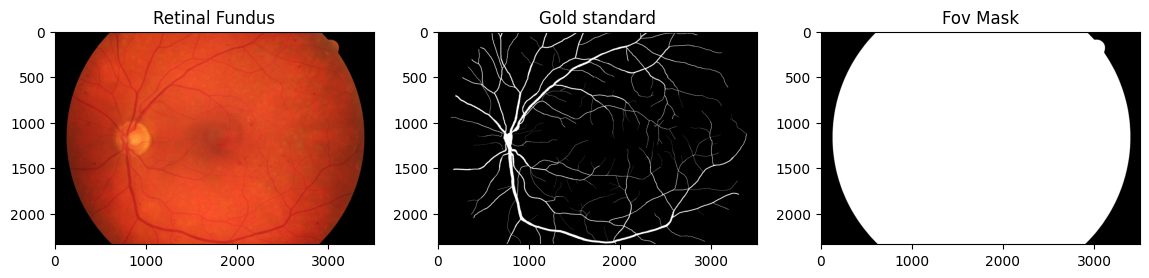

In [102]:
image, gs, fov = load_sample_data(EXAMPLE_SAMPLE)
plt_show_sample(image, gs, fov)

### 1. Computer Vision

Ta sekcja dotyczy zastosowania metod **Computer Vision** a w szczególności filtrów typu _ridge-filters_ do klasyfikacji binarnej naczyń dna siatkówki oka. Do rozwiązania tego problemu, stosujemy metody preprocessingu w postaci normalizacji histogramu, processingu w postaci filtru _Sato_ oraz postprocessingu w postaci rozmycia Gausowskiego.

#### 1.1 Funkcje 

Korzystamy z gotowej implementacji filtru `sato` z biblioteki `skimage.filters`. Pozostałe funkcje wykorzystują metody biblioteki `cv2`. W trakcie analizy, zauważyliśmy, że dominujące znaczenie w jakości klasyfikatora, ma wybrany kanał kolorów (`r`, `g`, `b`). Funkcja `combine_channels` ma za zadanie agregować wyniki obliczone dla każdego kanału za pomocą średniej ważonej, aby skupić się na kanałach które przekazują najwięcej informacji o naczyniach. 

In [105]:
from skimage.filters import sato

def combine_channels(r, g, b, threshold: int, weights: List[float]):
    """ Merge 3-color channels into one using weighted sum. Return thresholded image. """
    assert sum(weights) <= 1.0

    result = np.average([r, g, b], weights=weights, axis=0)
    _, mask = cv2.threshold(result, threshold, 255, cv2.THRESH_BINARY)
    return mask
    
def ridge_detect_channel(channel: np.ndarray):
    """ Use sato filter. Make sure vessels are white on given image. """
    return sato(channel, black_ridges=False)
    
def preprocess_channel(channel: np.ndarray):
    image = cv2.equalizeHist(channel)
    image = cv2.bitwise_not(image)
    return image
    
def postprocess_channel(channel: np.ndarray, blur_kernel_size = 19):
    # assume: uint8
    return cv2.GaussianBlur(channel, (blur_kernel_size, blur_kernel_size), 0)

#### 1.2 Solver 

Zaimplementowany przez nas `Solver` przyjmuje 3 główne parametry:
- `threshold` -> wartość całkowitą z przedziału [`0`, `255`] wykorzystywaną przy agregacji kanałów
- `channel_weights` -> tablica wag, znormalizowanych aby w sumie dawać wartość `1.0` 
- `blur_kernel_size` -> rozmiar jądra wykorzystywanego przez `GaussianBlur`

Funkcja `generate_mask` przedstawia cały proces otrzymywania maski klasyfikacji na podstawie obrazu oraz maski FOV. Cały proces został dokładniej opisany w następnej sekcji.

In [14]:
class CVSolver:
    def __init__(self, threshold: int, channel_weights: List[float], blur_kernel_size: int):
        self.threshold = threshold
        self.channel_weights = channel_weights 
        self.blur_kernel_size = blur_kernel_size 
    
    def __str__(self):
        return "cv"

    def generate_mask(self, image, fov): 
        """ Full image processing using only Computer Vision methods. Return binary classification mask """
        
        r, g, b = cv2.split(image)

        r_pre, g_pre, b_pre = map(preprocess_channel, (r, g, b))
        r_ridge, g_ridge, b_ridge = map(ridge_detect_channel, (r_pre, g_pre, b_pre))

        normalize = lambda x: (x - x.min()) / (x.max() - x.min()) * 255
        r_norm, g_norm, b_norm = map(normalize, (r_ridge, g_ridge, b_ridge))
        r_post, g_post, b_post = map(postprocess_channel, (r_norm, g_norm, b_norm), [ self.blur_kernel_size ] * 3) 

        mask = combine_channels(r_post, g_post, b_post, threshold=self.threshold, weights=self.channel_weights)

        return mask

#### 1.3 Proces przetwarzania

Sekcja przedstawia efekt przetwarzania obrazu metodami Computer Vision, krok po kroku.

Możemy zauważyć, że każdy z kolorów niesie inną ilość informacji odnośnie znajdujących się w siatkówce naczyń. Na pierwszy rzut oka, kanał zielony jest najbardziej cennym źródłem informacji, zaraz za nim znajduje się kanał czerowony i kanał niebieski na samym końcu. Wykorzystujemy tą informację później przy przydzielaniu wag dla kanałów.

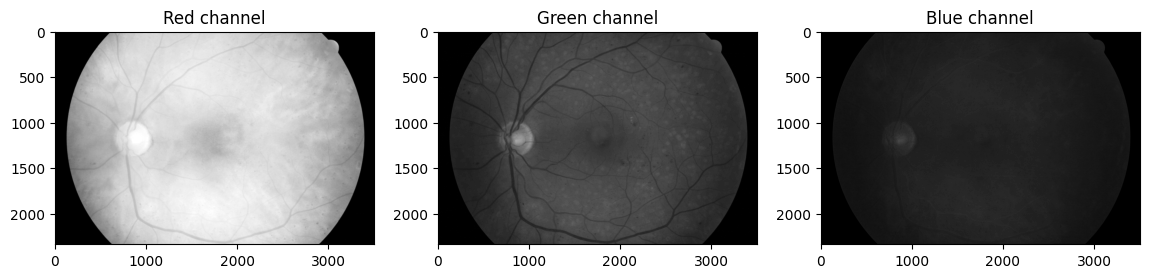

In [11]:
r, g, b = cv2.split(image)
plt_show_channels(r, g, b)

Każdy kanał zostaje wstępnie przetworzony za pomocą normalizacji histogramu oraz odwrócenia kolorów aby operować na białych naczyniach.

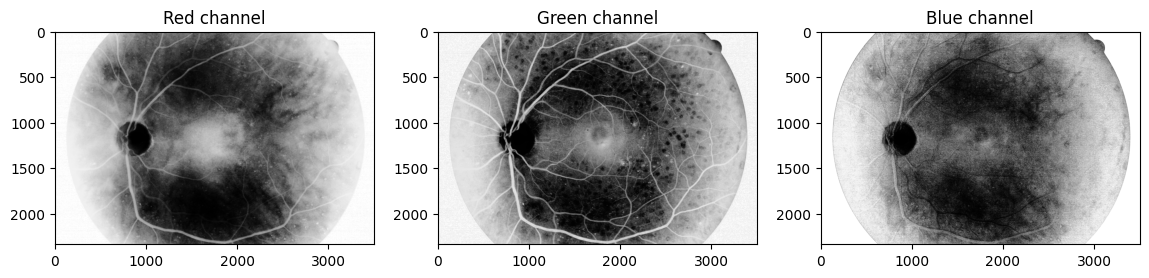

In [12]:
r_pre, g_pre, b_pre = map(preprocess_channel, (r, g, b))
plt_show_channels(r_pre, g_pre, b_pre)

Dla każdego kanału aplikujemy filtr `sato`. W naszych eksperymentach, próbowaliśmy również użyć filtru Frangiego (`frangi`), natomaist dawał on gorsze rezultaty.

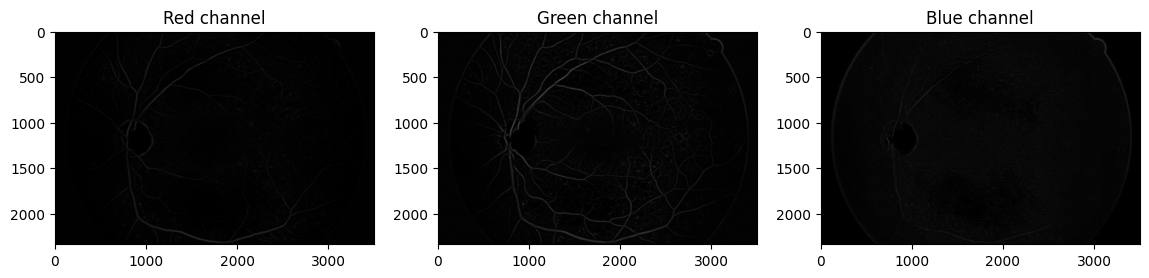

In [13]:
r_ridge, g_ridge, b_ridge = map(ridge_detect_channel, (r_pre, g_pre, b_pre))
plt_show_channels(r_ridge, g_ridge, b_ridge)

Ze względu na bardzo ciemny efekt działania filtru, aplikujemy normalizację dla każdego kanału.

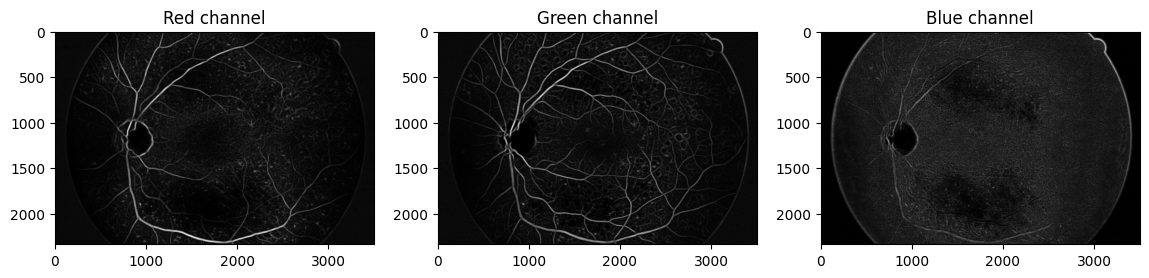

In [14]:
normalize = lambda x: (x - x.min()) / (x.max() - x.min()) * 255
r_norm, g_norm, b_norm = map(normalize, (r_ridge, g_ridge, b_ridge))
plt_show_channels(r_norm, g_norm, b_norm)

Po zaaplikowaniu filtru i normalizacji, możemy zauważyć wiele nieregularnych kształów (okręgów) znajdujących się dookoła naczyń. Ponieważ są to małe skupiska białych pikseli, staramy się zredukować ich wkład w wynikową maskę korzystając z rozmycia Gaussowskiego.

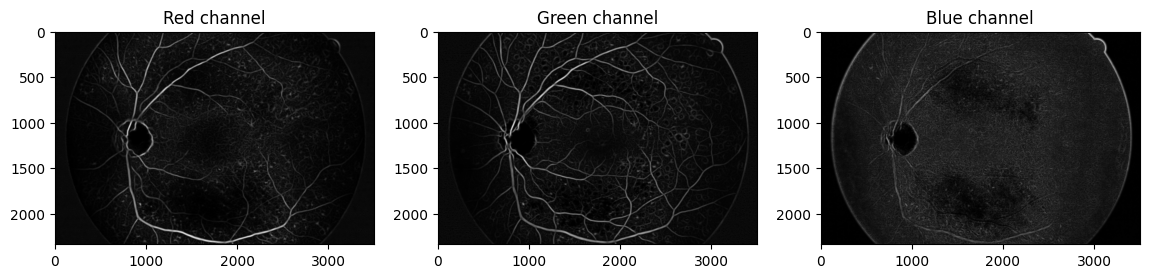

In [15]:
r_post, g_post, b_post = map(postprocess_channel, (r_norm, g_norm, b_norm), [ 11 ] * 3) 
plt_show_channels(r_post, g_post, b_post)

Otrzymane w ten sposób, przetworzone kanały, łączymy wykorzystując wagi `0.3`, `0.7` oraz `0` dla kanałów `r`, `g`, oraz `b`. Wartość `threshold=55` została dobrana empirycznie aby dawać najlepsze rezultaty.

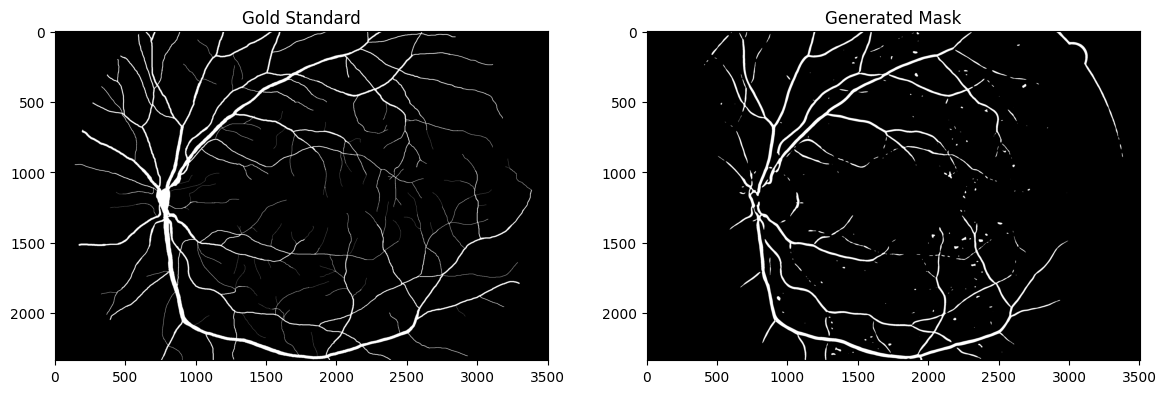

In [16]:
mask = combine_channels(
    r_post, g_post, b_post, 
    threshold=55, 
    weights=[0.3, 0.7, 0],
)

plt_compare_two_images(gs, mask, title1 = "Gold Standard", title2 = "Generated Mask", grayscale=True)

Dla otrzymanej w ten sposób przykładowej maski obliczamy wszystkie wspomniane wyżej miary klasyfikacji oraz wypisujemy je poniżej.

In [17]:
print_statistics(gs, mask)

Accuracy: 66.00%
Sensitivity: 98.44%
Specificity: 56.67%
Mean(spec, sens): 77.55%
GeoMean(spec, sens): 74.69%


#### 1.4 Benchmark

Na podstawie dobranych parametrów, tworzymy Computer Vision Solver i uruchamiamy go na naszym zbiorze benchmarkowym.

In [33]:
cv_solver = CVSolver(
    threshold=55, 
    channel_weights=[0.3, 0.7, 0], 
    blur_kernel_size=11
)

In [34]:
cv_results = benchmark_method(BENCHMARK_SAMPLE_NAMES, cv_solver, force=False)

100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


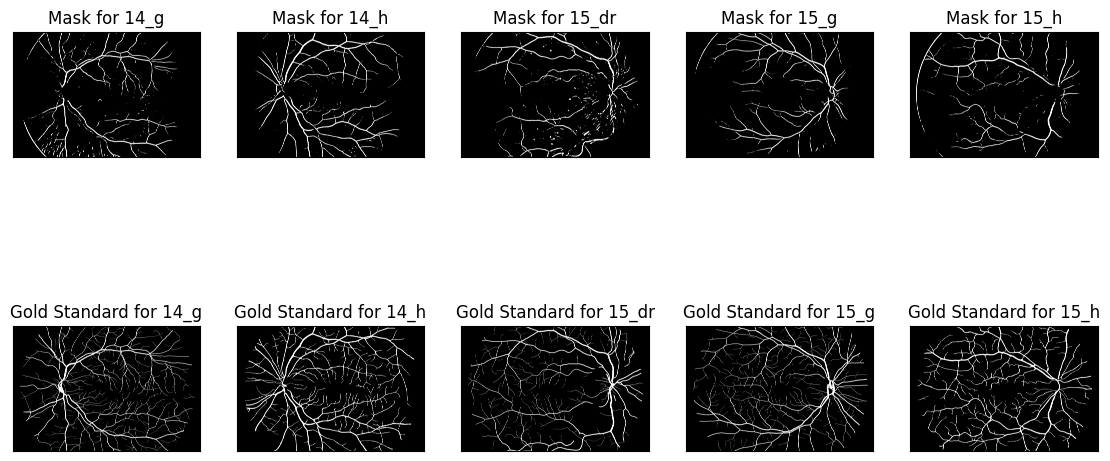

In [95]:
plt_show_benchmark_results(cv_results)

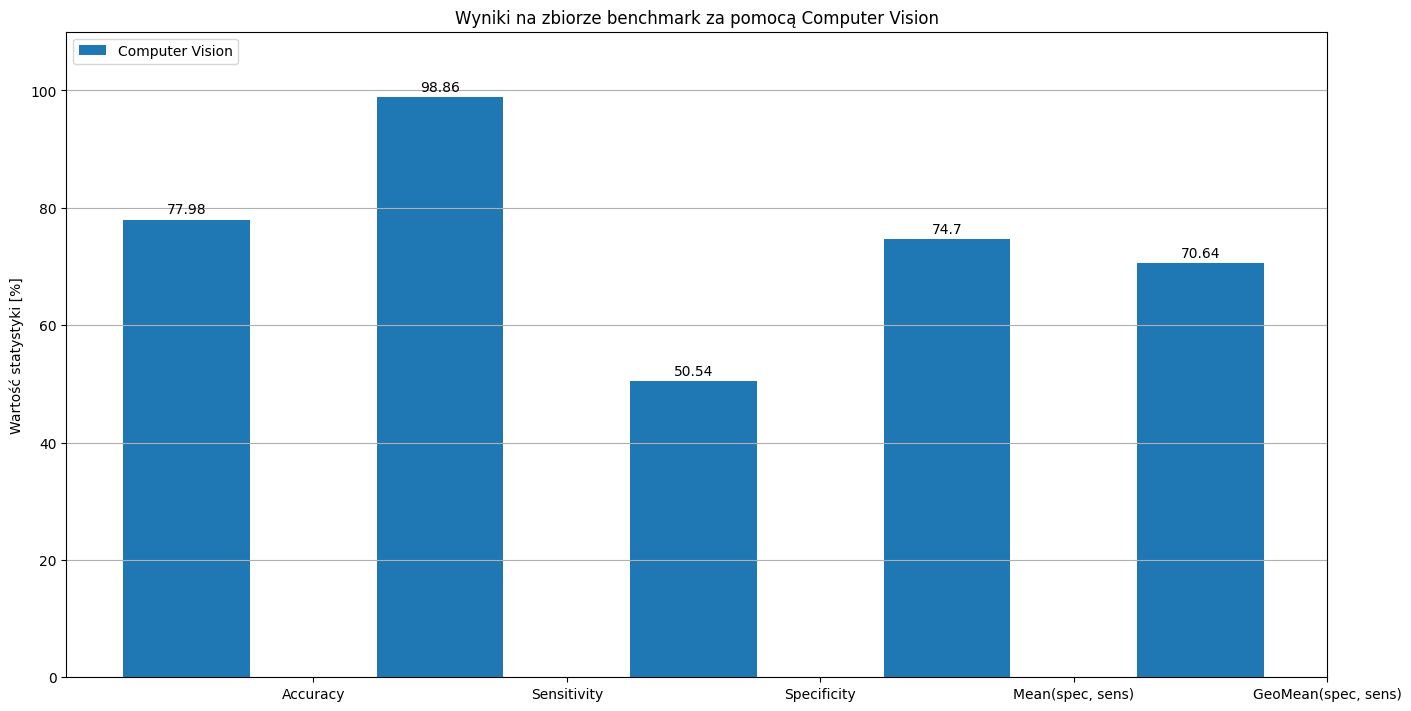

In [107]:
plt_show_benchmark_stats(cv_results, 'Computer Vision')

#### 1.5 Wnioski

Przedstawiona metoda Computer Vision jest prostą i nieskomplikowaną metodą. Do jej plusów zdecydowanie należy czas przetwarzania, ponieważ głównym nakładem czasowym jest zastosowanie tutaj filtru `sato`. Jak na swoją prostotę i szybkość przedstawia naprawdę dobre miary na poziomie **75** dla skuteczności (accuracy) oraz średniej z swoistości i czułości. 

Na podstawie przeprowadzonych obrazów możemy zauważyć, że głównym problemem jest brak łatwości odwzorowania mniej wyrazistych fragmentów naczyń. Duże fragmenty naczyń zostały z łatwością wyłapane przez filtr, pozostałe w wielu przypadkach zostały odrzucone przez odcięcie (`threshold`). Metoda dobrze odwzorowuje "charakter" naczyń, natomiast brakuje jej dużo szczegółowości aby być skuteczną.

### 2. Machine Learning

Ta sekcja dotyczy zastosowania metod **Machine Learning** a w szczególności klasyfikatora `RandomForest` do klasyfikacji binarnej naczyń dna siatkówki oka. W poszukiwaniu najlepszych hiperparametrów wykorzystujemy `RandomSearchCV`. Do poprawnej klasyfikacji, obraz dzielony jest na wycinki rozmiarów 5x5 px. Każdy otrzymany wycinek tworzy wektor cech, na które składają się:
- średnia wartość kanału zielonego
- odchylenie standardowe wartości koloru zielonego
- momenty Hu policzone dla kanału zielonego

Ponieważ takie przetwarzanie dla obrazów z bazy HRF jest czasochłonne, wykorzysujemy własne optymalizacje losowania zbioru treningowego i testowego. Zastosowana przez nas metoda ma też na celu wyrównanie nierówności (ang. **imbalance**) w dostarczonych danych, co pokażemy w procesie uczenia.

#### 2.1. Funkcje

Przedstawione poniżej funkcje służą do podziału obrazu na wycinki (`tile`) oraz otrzymania cech z danego wycinka.

In [38]:
from skimage.measure import moments_central, moments_normalized, moments_hu

def generate_tile_centers(image, fov_mask, tile_size, step_size = 1):
    rows, cols, channels = image.shape
    # step_size = tile_size//2 if overlapping else tile_size 
    for row in range(tile_size//2, rows - tile_size//2, step_size):
        for col in range(tile_size//2, cols - tile_size//2, step_size):
            if fov_mask[row, col] == 0: # or 0 if not
                continue

            yield (row, col)
            
def extract_tile_features(image, center, tile_size):
    row, col = center

    row1 = row - tile_size//2
    row2 = row + tile_size//2 + 1
    col1 = col - tile_size//2
    col2 = col + tile_size//2 + 1
    green = image[row1:row2, col1:col2 , 1]

    green_avg = np.average(green) / 255
    green_std = np.std(green) / 255

    g = green.astype('float64')
    g /= 255
    mu = moments_central(g)
    nu = moments_normalized(mu)
    hu_moments = moments_hu(nu)

    # x = green.flatten()
    x = np.hstack((green_avg, green_std, hu_moments))
    
    return x

#### 2.2. Solver

Zaimplementowany prez nas Machine Learning Solver przedstawia cały proces generowania maski klasyfikacji dla danego obrazu posiadając już wyuczony model. Ponieważ dostarczone zdjęcia są w dużej rozdzielczości, proces jest naprawdę czasochłonny i może potrwać nawet do godziny. Proces dzieli się na 3 etapy:
- Podziel dostarczony obraz na wycinki
- Wygeneruj wektor cech `X` na postawie danych wycinków
- Za pomocą predykcji klasyfikatora, oznacz odpowiednie piksele w masce

In [39]:
class MLSolver:
    def __init__(self, classifier, tile_size: int, step_size: int = 1):
        self.classifier = classifier
        self.tile_size = tile_size
        self.step_size = step_size
        
    def __str__(self):
        return "ml"
    
    # time consuming!
    def generate_mask(self, image, fov):
        centers = list(generate_tile_centers(
            image, fov, self.tile_size, self.step_size
        ))
        
        X = [ extract_tile_features(image, (row, col), self.tile_size) for (row, col) in centers ]
            
        mask = np.zeros_like(fov)
        y_pred = self.classifier.predict(X)
        for (row, col), decision in zip(centers, y_pred):
            if decision == 1: mask[row, col] = 255
                
        return mask

#### 2.3 Trenowanie klasyfikatora

Poniżej przedstawiony jest cały proces uczenia klasyfikatora. Pierwszym etapem jest stworzenie zbioru treningowego. Funkcja `generate_image_X_y` jest odpowiedzielna ze generowanie cech dla jednego zdjęcia dna oka. Wykorzystana optymalizacja polega na zebraniu najpierw coordynatów wybranych wycinków obrazu (`tile`) a następnie wybranie próby (`random.sample`) bez wywoływania czasochłonnych funkcji do otrzymania cech z wycinka. W ten sposób zapewniamy rozwiązanie braku zbalansowania dostarczonych danych. Funkcja `bulk_generate_X_y` odpowiada za zebranie równej liczby danych z każdego zdjęcia.

In [108]:
import random

def generate_image_X_y(sample_name: str, tile_size: int, tiles_per_image: int, pos_neg_ratio: float, step_size: int):
    image, gs, fov = load_sample_data(sample_name)

    tile_centers = list(generate_tile_centers(
        image=image, fov_mask=fov,
        step_size=step_size, tile_size=tile_size
    ))
    positive_tile_centers = []
    negative_tile_centers = []

    for (row, col) in tile_centers:
        if gs[row, col] > 0:
            positive_tile_centers.append((row, col))
        else:
            negative_tile_centers.append((row, col))

    n_positive_tiles = int(tiles_per_image * pos_neg_ratio)
    n_negative_tiles = tiles_per_image - n_positive_tiles
    assert n_negative_tiles > 0 and n_positive_tiles > 0

    # proper imbalance handling - select random sample equal to given proportion between P and N
    pos_coords = random.sample(positive_tile_centers, n_positive_tiles)
    neg_coords = random.sample(negative_tile_centers, n_negative_tiles)

    test_coords = pos_coords + neg_coords
    random.shuffle(test_coords)
    
    X = []
    y = []
    for row, col in test_coords:
        x = extract_tile_features(
            image=image, center=(row, col), tile_size=tile_size
        )
        X.append(x)
        decision = 1 if gs[row, col] == 255 else 0 
        y.append(decision)
    return (X, y)
    
def bulk_generate_X_y(sample_names: List[str], tile_size: int, n_tiles_all: int, pos_neg_ratio: float, step_size: int):
    X = []
    y = []
    assert len(sample_names) > 0

    n_tiles_per_image = n_tiles_all // len(sample_names)
    n_tiles_mod = n_tiles_all % len(sample_names)

    for i, sample_name in enumerate(tqdm(sample_names)):
        # split samples in a way that they sum up to n_tiles_all
        # even if divides with reminder
        n_tiles = n_tiles_per_image + (1 if i < n_tiles_mod else 0)
        new_X, new_y = generate_image_X_y(sample_name, tile_size, n_tiles, pos_neg_ratio, step_size)
        X.extend(new_X)
        y.extend(new_y)
    return (X, y)

Wywołujemy zaimplementowane funkcje dla 6 pierwszych zdjęć treningowych, chcąc otrzymać wektor cech o długości `100000`. Wykorzystujemy tutaj również parametr `pos_neg_ratio` który oznacza proporcję między klasami `P` oraz `N` na poziomie `0.4`. Parametr `tile_size` wyznacza nam rozmar okna w pikselach (`5x5`). Definiując `step_size` przyśpieszamy proces losowania, ponieważ nie przechodzimy po wszystkich pikselach obrazu.

In [109]:
n_train_images = 6
train_sample_names = TRAIN_SAMPLE_NAMES[:n_train_images]
n_train_tiles = 100000

X, y = bulk_generate_X_y(
    sample_names=train_sample_names, 
    tile_size=5,
    n_tiles_all=n_train_tiles,
    pos_neg_ratio=0.4,
    step_size=5
)
assert len(X) == n_train_tiles

100%|██████████| 6/6 [00:27<00:00,  4.52s/it]


Jak możemy zauważyć klasy pozostają zrównoważone w zdefiniowanej proporcji.

In [110]:
from collections import Counter
print(f"Classes counts: {Counter(y)}")

Classes counts: Counter({0: 60004, 1: 39996})


In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

W celu przeszukania przestrzeni hiperparametrów klasyfikatora `RandomForest` definiujemy zbiór parametrów oraz korzystamy z algorytmu `RandomizedSearchCV`. Przedstawione poniżej parametry są wynikiem wielokrotnego dostrajania i są obecnie dobrane tak aby klasyfikator nie decydował się na skrajną wartość.

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier()
parameters= { 
    'n_estimators': [500, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [7,8,9,10,11],
    'criterion' :['gini', 'entropy']
}
random_src = RandomizedSearchCV(estimator=clf, param_distributions = parameters,
                               cv = 5, n_iter = 10, n_jobs=-1)

In [ ]:
random_src.fit(X_train, y_train)

In [115]:
print(f"{random_src.best_estimator_ = }")
print(f"{random_src.best_params_ = }")

random_src.best_estimator_ = RandomForestClassifier(criterion='entropy', max_depth=10, max_features='auto',
                       n_estimators=600)
random_src.best_params_ = {'n_estimators': 600, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy'}


In [117]:
y_pred = random_src.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     18034
           1       0.76      0.69      0.72     11966

    accuracy                           0.79     30000
   macro avg       0.78      0.77      0.78     30000
weighted avg       0.79      0.79      0.79     30000



Wytrenowany klasyfikator zapisujemy do pliku.

In [ ]:
import joblib
joblib.dump(random_src, 'random_search_cv.pkl')

#### 2.4 Benchmark

Wytrenowany klasyfikator testujemy na zbiorze benchmarkowym.

In [40]:
import joblib
rnd_src = joblib.load("random_search_cv.pkl")
print(rnd_src.best_params_)
classifier = rnd_src.best_estimator_
print(classifier)

{'n_estimators': 600, 'max_features': 'log2', 'max_depth': 9, 'criterion': 'gini'}
RandomForestClassifier(max_depth=9, max_features='log2', n_estimators=600)


In [41]:
ml_solver = MLSolver(
    classifier=classifier,
    tile_size=5,
    step_size=1,
)

In [43]:
ml_results = benchmark_method(BENCHMARK_SAMPLE_NAMES, ml_solver, force=False)

100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


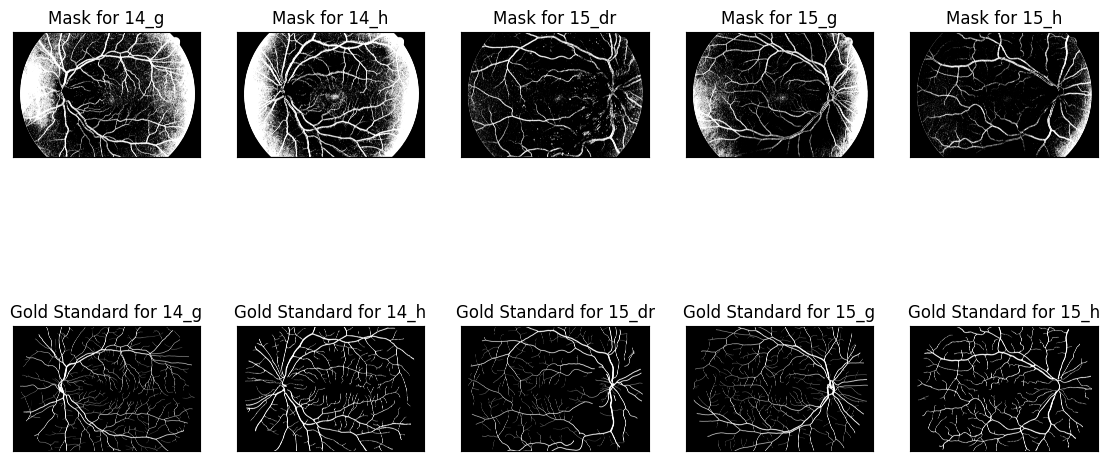

In [125]:
plt_show_benchmark_results(ml_results)

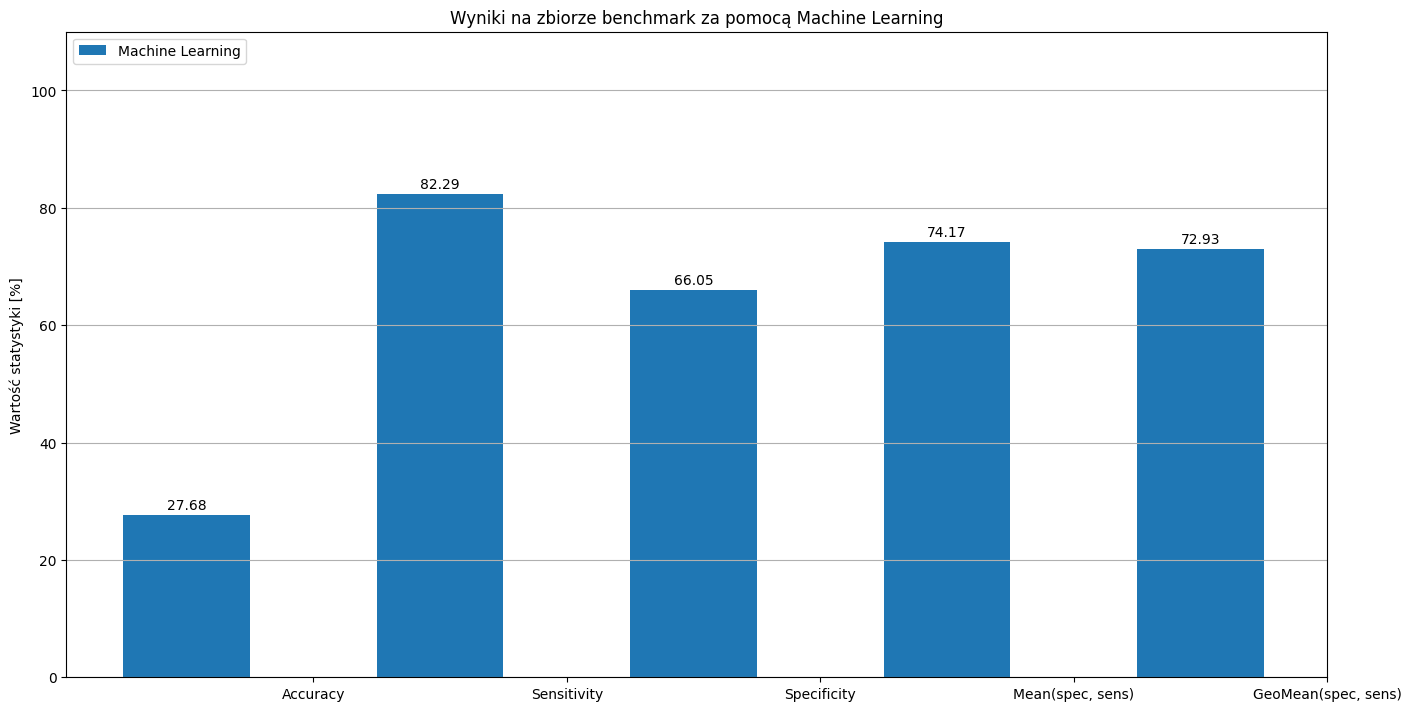

In [126]:
plt_show_benchmark_stats(ml_results, "Machine Learning")

#### 2.5 Wnioski

Zastosowana metoda Machine Learning bardzo dobrze potrafi odwzorować zarówno większe jak i mniejsze fragmenty naczyń. Największą wadą tej metody jest niska skuteczność co może wynikać z paru problemów:
- Brak wystarczającej liczby danych -> na wygenerowanych maskach można zauważyć duże fragmenty fałszywego przypisania obszaru jako naczynie przy skrajnych punktach siatkówki. 
- Nierówny rozkład -> Dodatkowym czynnikiem może być wynik zgromadzenia większości danych z losowania w centralnej częsci oka, gdzie dużo prościej odróżnić naczynie od tła. 
- Brak odpowiedniego preprocessingu -> Po załączonych obrazach można zauważyć duże "plamy" / efekty świetlne znajdujące się w prawej i lewej częsci siatkówki, które znacząco mogą utrudniać poprawną identyfikację na podstawie kanału kolorów. 

Dodatkowym problemem jest długi czas oczekiwania na przetworzenie. Ponieważ nasza klasyfikacja odbywa się na zasadach "piksel-per-piskel", musimy przejść przez wszystkie piksele obrazu, i dla każdego z nich wygenerować cechy. Jest to czasochłonny proces, który powoduje czasy geneowania na poziomie 40 minut dla jednego zdjęcia.

### 3. Deep Learning

Ta sekcja dotyczy zastosowania metod **Deep Learning** a w szczególności sieci typu _U-net_ do klasyfikacji binarnej naczyń dna siatkówki oka. Do rozwiązania tego problemu, stosujemy metody zaimplementowane w bibliotece `keras`.


#### 3.1 Funkcje

Poniżej znajdują się implementacje funkcji przeznaczone do odtwarzania oraz konwertowania obrazu na wycinki w celu obróbki przez resztę funkcji bilbioteki `keras`. Ich implementacja była konieczna ze względu na problemy z bilbioteką `kutils`.

In [52]:
import keras
from keras_unet.metrics import iou
import cv2
import numpy as np

PATCH_SIZE = 256
PATCH_STRIDE = 64

def get_patches(img, size, stride):
    org_img_size = img.shape[1:4]

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    patches = np.zeros((i_max * j_max, size, size, org_img_size[2]))

    k = 0
    for i in range(i_max):
        for j in range(j_max):
            patches[k] = img[ 0, i * stride : i * stride + size, j * stride : j * stride + size, : ]
            k += 1
    
    return patches

def reconstruct(img, org_img_size, size, stride, average=False):
    pp = np.zeros(org_img_size)

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    if average:
        mask = np.zeros_like(pp)

    kk = 0
    for i in range(i_max):
        for j in range(j_max):
            pp[ i * stride : i * stride + size, j * stride : j * stride + size ] += img[kk, :, :, :]

            if average:
                mask[ i * stride : i * stride + size, j * stride : j * stride + size ] += 1

            kk += 1
    
    if average:
        mask[mask == 0] = 1
        pp /= mask
    
    return pp

def threshold(img, t):
    nimg = np.zeros_like(img)

    nimg[img < t] = 0
    nimg[img >= t] = 1

    return nimg

#### 3.2 Solver

Tak jak w przypadku pozostałych metod, tworzymy `Solver` przystosowany do generowania maski na podstawie dostarczonego zdjęcia. Cały proces został dogłębnie przedstawiony w dalszych sekcjach.

In [53]:
class DLSolver:
    def __init__(self, model, patch_size: int, patch_stride: int, threshold: float, blur_kernel_size: int):
        self.model = model
        self.patch_size = patch_size
        self.patch_stride = patch_stride
        self.threshold = threshold
        self.blur_kernel_size = blur_kernel_size

        assert self.threshold <= 1.0
        
    def __str__(self):
        return "dl"
    
    def generate_mask(self, image, fov):
        xx = np.array([image], dtype=np.float32)
        x_test = get_patches(
            xx,
            size=self.patch_size,
            stride=self.patch_stride
        )
        y_pred = self.model.predict(x_test)
        pp = reconstruct(y_pred, xx.shape[1:4], size=self.patch_size, stride=self.patch_stride, average=True)
        pb = cv2.blur(pp, (self.blur_kernel_size, self.blur_kernel_size))
        
        mask_float = cv2.threshold(pb, self.threshold, 1.0, cv2.THRESH_BINARY)[1]
        # select one of three channels, convert [0.,1.] -> [0, 255]
        mask = (mask_float * 255).astype(np.uint8)[:, :, 0]
        return mask


#### 3.3 Trenowanie Modelu

Trenowanie modelu, ze względu na czasochłonność miało miejsce na platformie Google Collab.

In [49]:
import keras_unet.utils as kutils
import numpy as np
import matplotlib.pyplot as plt
import keras


PATCH_SIZE = 256
PATCH_STRIDE = 128

def get_batch_names(sample_names, num_batches):
    return np.array_split(sample_names, num_batches)

def get_batch_data(sample_names, val_sample_names, patch_size=PATCH_SIZE, patch_stride=PATCH_STRIDE):
    x_train = kutils.get_patches(
        np.array([load_image(path) for path in sample_names], dtype=np.float32),
        size=patch_size,
        stride=patch_stride
    )
    y_train = kutils.get_patches(
        np.expand_dims(np.array([load_gold_standard(path) for path in sample_names], dtype=np.float32), -1),
        size=patch_size,
        stride=patch_stride
    )
    x_val = kutils.get_patches(
        np.array([load_image(path) for path in val_sample_names], dtype=np.float32),
        size=patch_size,
        stride=patch_stride
    )
    y_val = kutils.get_patches(
        np.expand_dims(np.array([load_gold_standard(path) for path in val_sample_names], dtype=np.float32), -1),
        size=patch_size,
        stride=patch_stride
    )

    x_train /= 255
    y_train /= 255
    x_val /= 255
    y_val /= 255
    
    return x_train, y_train, x_val, y_val


In [ ]:
# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=0)
# x_len = x_train.shape[0] + x_val.shape[0]
# train_data = kutils.get_augmented(x_train, y_train)

In [ ]:
from keras_unet.models import custom_unet
from keras_unet.metrics import iou, iou_thresholded
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.optimizers import SGD
import os

x_train = kutils.get_patches(
    np.array([load_image(path) for path in ['01_dr']]),
    size=PATCH_SIZE,
    stride=PATCH_STRIDE
)

model = custom_unet(input_shape=x_train[0].shape)

checkpoint_callback = ModelCheckpoint(
    'fundus_segm_v1.h5',
    monitor='val_loss',
    save_best_only=True
)

if os.path.exists("model_history_log.csv"):
    os.remove("model_history_log.csv")

csv_logger = CSVLogger("model_history_log.csv", append=True)

model.compile(
    SGD(learning_rate=0.01),
    "binary_crossentropy",
    metrics=[iou]
)

In [ ]:
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
import gc

batch_size = 16

sample_names = list(filter(lambda x: '0' in x and '9' not in x, get_all_sample_names()))
val_sample_names = list(filter(lambda x: '09' in x, get_all_sample_names()))

for i in range(4):
    print('real epoch', i, 'starts here.')
    for batch_names in get_batch_names(sample_names, 9):
        gc.collect()
        
        x_train, y_train, x_val, y_val = get_batch_data(batch_names, val_sample_names)

        # train_data = kutils.get_augmented(x_train, y_train)

        # model.fit_generator(
        #     train_data,
        #     steps_per_epoch=2,
        #     epochs = 1,
        #     validation_data=(x_val, y_val),
        #     callbacks=[checkpoint_callback, csv_logger]
        # )

        model.fit(
            x_train,
            y_train,
            batch_size = 64,
            epochs = 1,
            validation_data=(x_val, y_val),
            callbacks=[checkpoint_callback, csv_logger]
        )

        del x_train
        del y_train
        del x_val
        del y_val

model.save('fundus_segm_v1_final.h5')

real epoch 0 starts here.
14/14 [==============================] - 16s 1s/step - loss: 0.0913 - iou: 0.5518 - val_loss: 0.0737 - val_iou: 0.5432
real epoch 1 starts here.
14/14 [==============================] - 16s 1s/step - loss: 0.1192 - iou: 0.4959 - val_loss: 0.0797 - val_iou: 0.5390


KeyboardInterrupt: ignored

#### 3.4 Proces przetwarzania

Poniżej znajduje się przedstawiony proces dobierania parametrów postprocessingu otrzymanych zdjęć z wytrenowanego modelu. Obserwując wynikową maskę dla różnych wartości odcięcia `threshold`, dobieramy finalną wartość `0.8`.

(1, 2336, 3504, 3) (1683, 256, 256, 3)
53/53 [==============================] - 168s 3s/step
(1683, 256, 256, 3) (1683, 256, 256, 1)


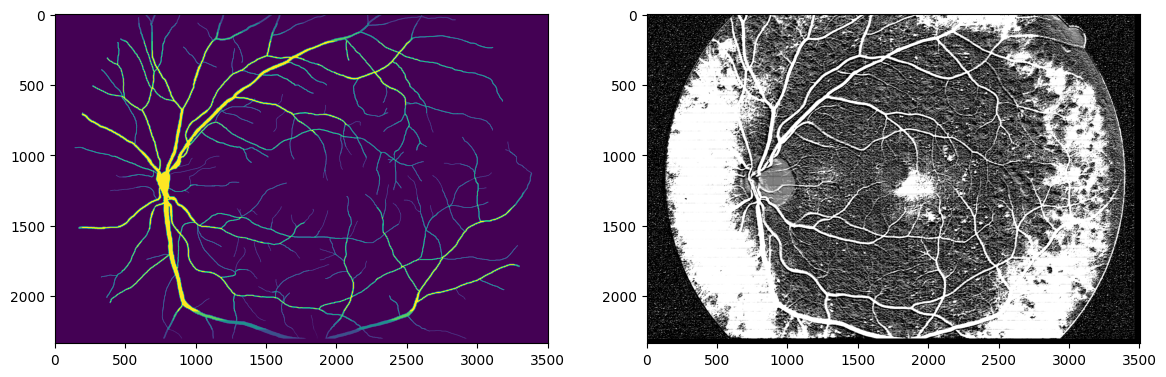

In [118]:
model = keras.models.load_model('fundus_segm_v1.h5', custom_objects={'iou': iou})

xx = np.array([load_image(EXAMPLE_SAMPLE)], dtype=np.float32)
x_test = get_patches(
    xx,
    size=PATCH_SIZE,
    stride=PATCH_STRIDE
)

yy = np.expand_dims(np.array([load_gold_standard(EXAMPLE_SAMPLE)], dtype=np.float32), -1)
y_test = get_patches(
    yy,
    size=PATCH_SIZE,
    stride=PATCH_STRIDE
)

print(xx.shape, x_test.shape)
y_pred = model.predict(x_test)
print(x_test.shape, y_pred.shape)
pp = reconstruct(y_pred, xx.shape[1:4], size=PATCH_SIZE, stride=PATCH_STRIDE, average=True)

plt.subplot(121)
plt.imshow(reconstruct(y_test, yy.shape[1:4], size=PATCH_SIZE, stride=PATCH_STRIDE).squeeze())
plt.subplot(122)
plt.imshow(pp)

(array([12147279.,   163866.,   846138.,    99366.,   103989.,   203850.,
          137172.,   962970.,   232686.,  9658716.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

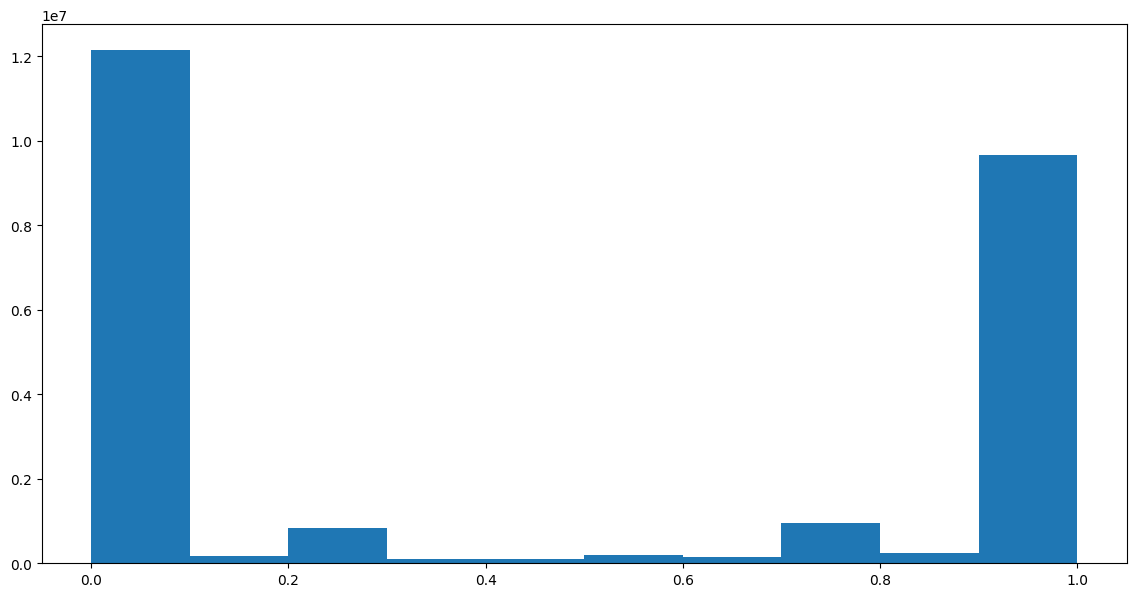

In [119]:
plt.hist(pp.flatten())

In [120]:
pb = cv2.blur(pp, (8, 8))

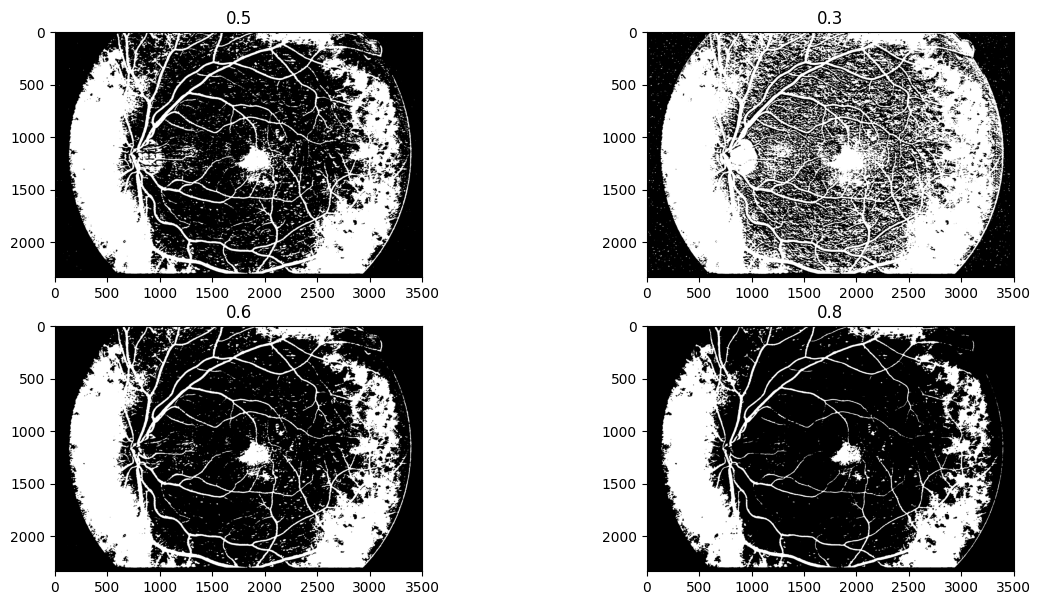

In [121]:
plt.subplot(221)
plt.title('0.5')
plt.imshow(cv2.threshold(pb, 0.5, 1.0, cv2.THRESH_BINARY)[1])
plt.subplot(222)
plt.title('0.3')
plt.imshow(cv2.threshold(pb, 0.3, 1.0, cv2.THRESH_BINARY)[1])
plt.subplot(223)
plt.title('0.6')
plt.imshow(cv2.threshold(pb, 0.6, 1.0, cv2.THRESH_BINARY)[1])
plt.subplot(224)
plt.title('0.8')
plt.imshow(cv2.threshold(pb, 0.8, 1.0, cv2.THRESH_BINARY)[1])

#### 3.5 Benchmark

In [54]:
dl_solver = DLSolver(
    model=keras.models.load_model('fundus_segm_v1.h5', custom_objects={'iou': iou}),
    patch_size=PATCH_SIZE,
    patch_stride=PATCH_STRIDE,
    threshold=0.8,
    blur_kernel_size=8
)

In [55]:
dl_results = benchmark_method(BENCHMARK_SAMPLE_NAMES, dl_solver, force=False)

100%|██████████| 5/5 [00:01<00:00,  3.72it/s]


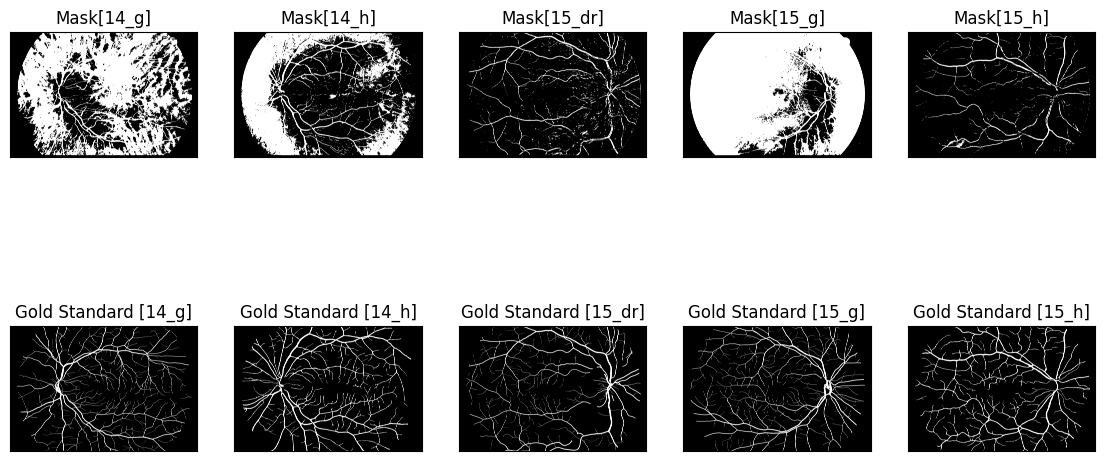

In [130]:
plt_show_benchmark_results(dl_results)

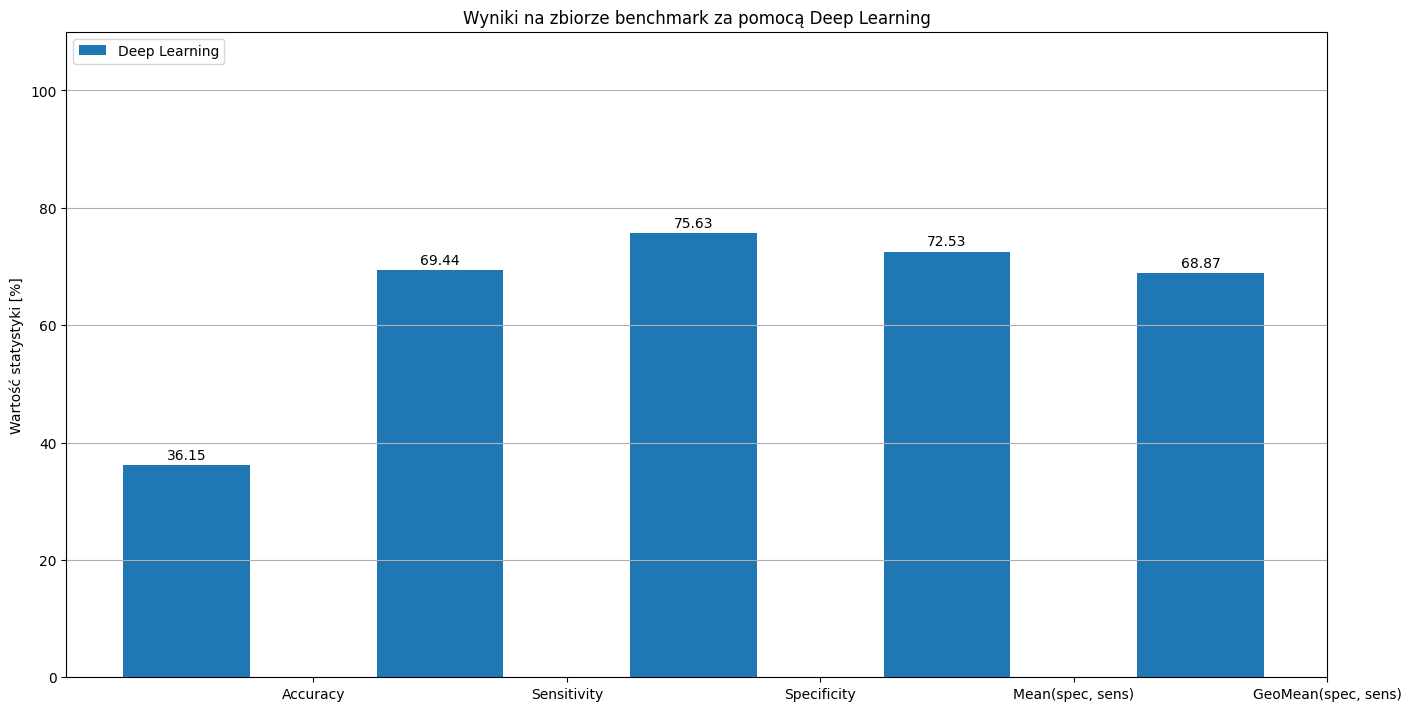

In [123]:
plt_show_benchmark_stats(dl_results, "Deep Learning")

#### 3.6 Wnioski



## Porównanie wyników

W tym segmencie przedstawiamy zestawienie wyników dla wszystkich wykorzystanych metod.

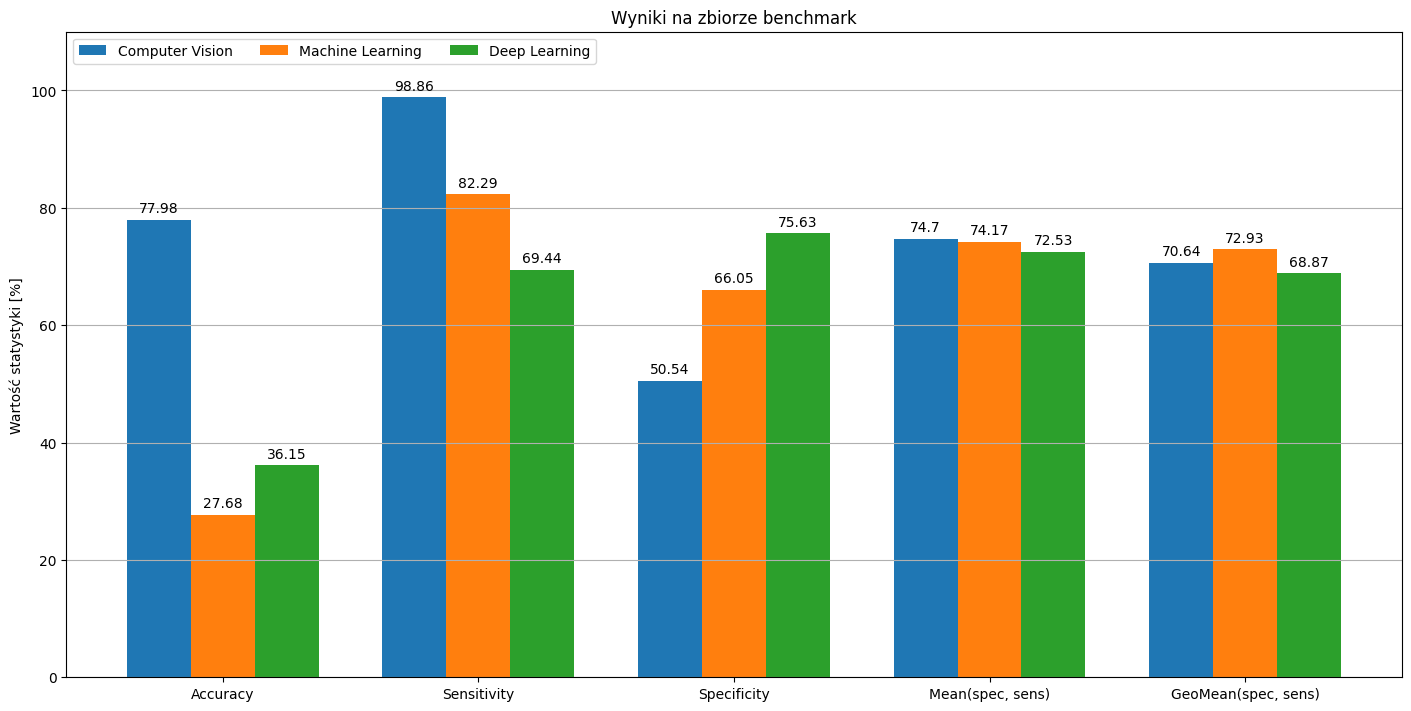

In [132]:
stats = ("Accuracy", "Sensitivity", "Specificity", "Mean(spec, sens)", "GeoMean(spec, sens)")

cv_stats, ml_stats, dl_stats = map(calculate_mean_mask_statistics, [cv_results, ml_results, dl_results]) 

solver_means = {
    "Computer Vision": tuple(round(100 * stat, 2) for stat in cv_stats),
    "Machine Learning": tuple(round(100 * stat, 2) for stat in ml_stats),
    "Deep Learning": tuple(round(100 * stat, 2) for stat in dl_stats),
}

x = np.arange(len(stats))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

ax.grid(axis='y')

for attribute, measurement in solver_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Wartość statystyki [%]')
ax.set_title(f'Wyniki na zbiorze benchmark')
ax.set_xticks(x + width, stats)

ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 110)

plt.show()
